In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [22]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from cloudpickle import load

try:
    from mlutils import eval_class_model
    v047 = False
except ImportError as e:
    from mlrun.mlutils import eval_class_model, gcf_clear
    v047 = True

from urllib.request import urlopen

def _plot_roc(
    context,
    y_labels,
    y_probs,
    key="roc",
    plots_dir: str = "plots",
    fmt="png",
    fpr_label: str = "false positive rate",
    tpr_label: str = "true positive rate",
    title: str = "roc curve",
    legend_loc: str = "best",
):
    """plot roc curves 
    
    replaces legacy version mlrun  v0.4.7
    
    :param context:      the function context
    :param y_labels:     ground truth labels, hot encoded for multiclass
    :param y_probs:      model prediction probabilities
    :param key:          ("roc") key of plot in artifact store
    :param plots_dir:    ("plots") destination folder relative path to artifact path
    :param fmt:          ("png") plot format
    :param fpr_label:    ("false positive rate") x-axis labels
    :param tpr_label:    ("true positive rate") y-axis labels
    :param title:        ("roc curve") title of plot
    :param legend_loc:   ("best") location of plot legend
    """
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from mlrun.artifacts import PlotArtifact
    # clear matplotlib current figure
    gcf_clear(plt)

    # draw 45 degree line
    plt.plot([0, 1], [0, 1], "k--")

    # labelling
    plt.xlabel(fpr_label)
    plt.ylabel(tpr_label)
    plt.title(title)
    plt.legend(loc=legend_loc)

    # single ROC or mutliple
    if y_labels.ndim > 1:
        # data accummulators by class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_labels[:, :-1].shape[1]):
            fpr[i], tpr[i], _ = metrics.roc_curve(
                y_labels[:, i], y_probs[:, i], pos_label=1
            )
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"class {i}")
    else:
        fpr, tpr, _ = metrics.roc_curve(y_labels, y_probs[:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f"positive class")

    fname = f"{plots_dir}/{key}.html"
    return context.log_artifact(PlotArtifact(key, body=plt.gcf()), local_path=fname)

def xgb_test(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    plots_dest: str = "plots",
    model_evaluator = None,
    default_model: str = "model.pkl"
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     model artifact to be tested
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param plots_dest:      dir for test plots
    :param model_evaluator: WIP: specific method to generate eval, passed in as string
                            or available in this folder
    :param default_model:   'model.pkl', default model artifact file name
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path.url, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except ValueError as va: 
        model_obj = load(urlopen(os.path.join(str(models_path), default_model)))
    except Exception as a:
        raise Exception("model location likely misspecified")

    if not model_evaluator:
        if v047:
            yprobs=model_obj.predict_proba(xtest)
            _plot_roc(context, ytest, yprobs, key="roc", plots_dir=plots_dest)
            from mlrun.mlutils import plot_importance
            context.header = list(xtest.columns)
            plot_importance(context, model_obj)
            eval_metrics = eval_class_model(xtest, ytest.values, model_obj)
        else:
            eval_metrics = eval_class_model(context, xtest, ytest, model_obj)
 
    if "tables" in eval_metrics.keys():
        model_tables = eval_metrics.pop("tables")
        for tbl in model_tables:
            context.log_artifact(tbl, local_path=f"{plots_dest}/{tbl.key}.csv")

    model_plots = eval_metrics.pop("plots")
    for plot in model_plots:
        context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")

    context.log_results(eval_metrics)

In [23]:
# nuclio: end-code

### mlconfig

In [24]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [25]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("xgb_test")

# add metadata (for templates and reuse)
fn.spec.default_handler = "xgb_test"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["ml", "test"]
fn.metadata.labels = {"author": "yjb", "framework": "xgboost"}
fn.export("function.yaml")

[mlrun] 2020-05-20 17:56:58,563 function spec saved to path: function.yaml


## tests

In [26]:
if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc('nfsvol', 'nfsvol', '/home/jovyan/data'))

In [27]:
task_params = {
    "name" : "tasks xgb test",
    "params": {
        "label_column"  : "labels",
        "plots_dest"    : "plots/xgb_test"}}

In [28]:
TEST_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master"
DATA_PATH  = "data/classifier-data.csv"
MODELS_PATH = "models/xgb_test"

### run locally

[mlrun] 2020-05-20 17:56:58,634 starting run tasks xgb test uid=22e4078558f34c549c459ce74adee0b6  -> http://mlrun-api:8080
[mlrun] 2020-05-20 17:56:58,973 log artifact calibration curve at /User/artifacts/plots/calibration curve.html, size: 28544, db: Y
[mlrun] 2020-05-20 17:56:59,102 log artifact learning curve - auc at /User/artifacts/plots/learning curve - auc.html, size: 16987, db: Y
[mlrun] 2020-05-20 17:56:59,196 log artifact learning curve - erreur at /User/artifacts/plots/learning curve - erreur.html, size: 15230, db: Y
[mlrun] 2020-05-20 17:56:59,505 log artifact feature-importances-tbl at /User/artifacts/plots/xgb_test/feature-importances-tbl.csv, size: 120, db: Y
[mlrun] 2020-05-20 17:56:59,640 log artifact feature-importances at /User/artifacts/plots/xgb_test/feature-importances.html, size: 14790, db: Y
[mlrun] 2020-05-20 17:56:59,691 log artifact confusion-matrix-normalized at /User/artifacts/plots/xgb_test/confusion-matrix-normalized.html, size: 10610, db: Y
[mlrun] 2020-

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...4adee0b6,0,May 20 17:56:58,completed,tasks xgb test,v3io_user=adminkind=handlerowner=adminhost=jupyter-67c88b95d4-crdhq,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,test-accuracy=0.964test-error=0.036rocauc=0.9845582259375362brier_score=0.026451627408418558f1-score=0.9552238805970149precision_score=0.964824120603015recall_score=0.9458128078817734,calibration curvelearning curve - auclearning curve - erreurfeature-importances-tblfeature-importancesconfusion-matrix-normalizedroc-binaryprecision-recall-binary


to track results use .show() or .logs() or in CLI: 
!mlrun get run 22e4078558f34c549c459ce74adee0b6 --project default , !mlrun logs 22e4078558f34c549c459ce74adee0b6 --project default
[mlrun] 2020-05-20 17:56:59,861 run executed, status=completed


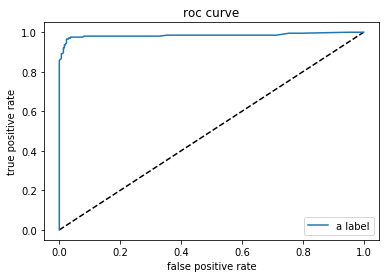

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

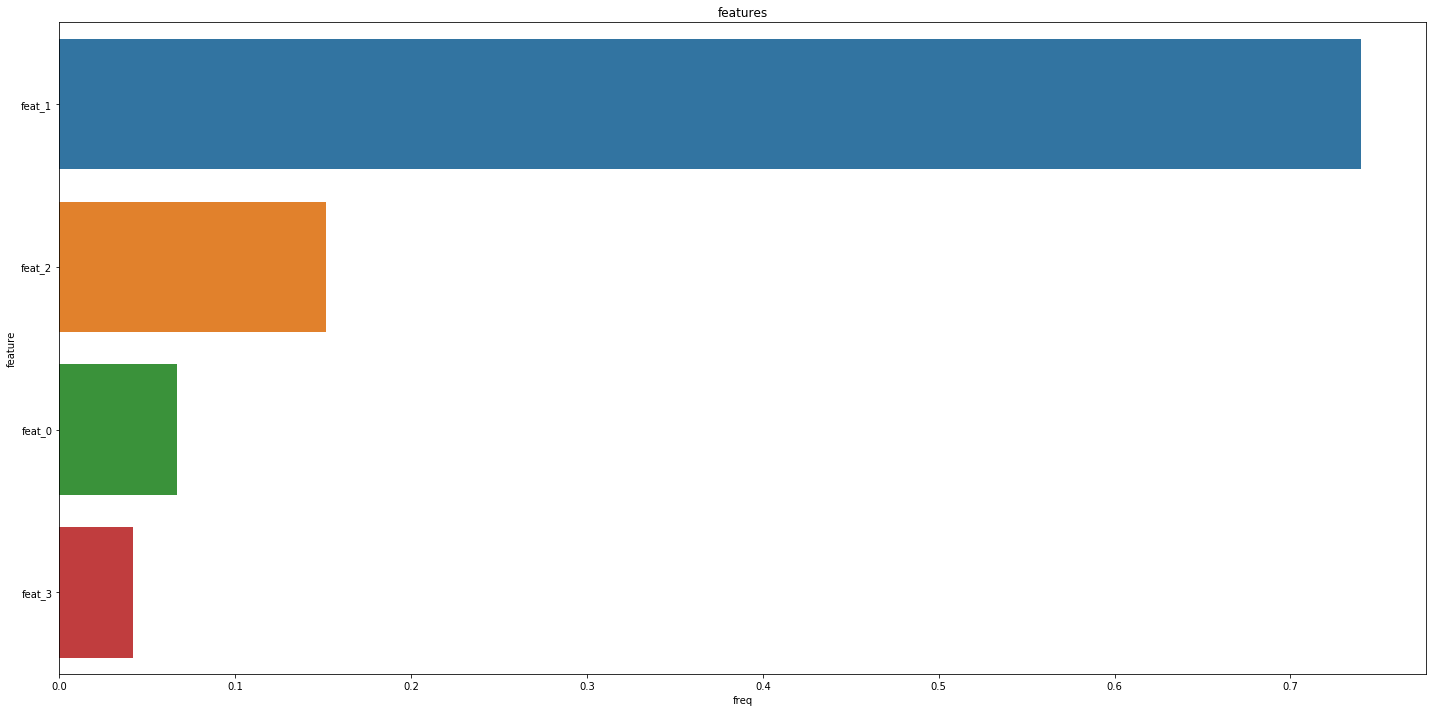

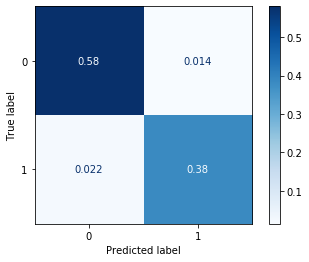

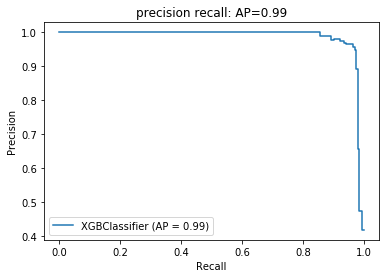

In [29]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=xgb_test,
                inputs={"test_set"      : f"{TEST_REPO}/{DATA_PATH}",
                        "models_path"   : f"{TEST_REPO}/{MODELS_PATH}"},
                workdir=mlconf.artifact_path)

In [30]:
fn.deploy(skip_deployed=True, with_mlrun=False)

run = fn.run(
    NewTask(**task_params),
    inputs={"test_set"      : f"{TEST_REPO}/{DATA_PATH}",
            "models_path"   : f"{TEST_REPO}/{MODELS_PATH}"
        },
    workdir=mlconf.artifact_path)

[mlrun] 2020-05-20 17:57:00,407 starting run tasks xgb test uid=a2089f4c6072421e8066e61690845515  -> http://mlrun-api:8080
[mlrun] 2020-05-20 17:57:00,503 Job is running in the background, pod: tasks-xgb-test-c4pqd
[mlrun] 2020-05-20 17:57:03,931 starting local run: main.py # xgb_test
No handles with labels found to put in legend.
[mlrun] 2020-05-20 17:57:05,168 log artifact roc at /User/artifacts/plots/xgb_test/roc.html, size: 32130, db: Y
[mlrun] 2020-05-20 17:57:05,414 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 28218, db: Y
[mlrun] 2020-05-20 17:57:05,429 log artifact feature-importances-tbl at /User/artifacts/feature-importances-tbl.csv, size: 120, db: Y
[mlrun] 2020-05-20 17:57:05,610 log artifact confusion-matrix at /User/artifacts/plots/xgb_test/confusion-matrix.html, size: 19615, db: Y

[mlrun] 2020-05-20 17:57:05,627 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...90845515,0,May 20 17:57:04,completed,tasks xgb test,host=tasks-xgb-test-c4pqdkind=jobowner=adminv3io_user=admin,models_pathtest_set,label_column=labelsplots_dest=plots/xgb_test,accuracy=0.964brier_score=0.026451627408418558rocauc=0.9845582259375362test-error-rate=0.036,rocfeature-importancesfeature-importances-tblconfusion-matrix


to track results use .show() or .logs() or in CLI: 
!mlrun get run a2089f4c6072421e8066e61690845515  , !mlrun logs a2089f4c6072421e8066e61690845515 
[mlrun] 2020-05-20 17:57:09,680 run executed, status=completed
